In [1]:
import matplotlib.pyplot as plt
import gudhi
from gudhi.wasserstein import wasserstein_distance
import torch
from torch.optim.lr_scheduler import LambdaLR

# Optimizing point sets
We are trying to generate a point set in the unit disk with large cycles. More precisely, we compute the persistent homology in dimension 1 of some filtration (we will try 3 versions) built on the points, and want to maximize its total persistence. For this, we define a loss function that rewards total persistence and penalizes points outside of the disk.
## Rips complex

In [2]:
def myloss(pts):
    rips = gudhi.RipsComplex(points=pts, max_edge_length=0.5)
    # .5 because it is faster and, experimentally, the cycles remain smaller
    st = rips.create_simplex_tree(max_dimension=2)
    st.compute_persistence()
    i = st.flag_persistence_generators()
    if len(i[1]) > 0:
        i1 = torch.tensor(i[1][0])  # pytorch sometimes interprets it as a tuple otherwise
    else:
        i1 = torch.empty((0, 4), dtype=int)
    # Same as the finite part of st.persistence_intervals_in_dimension(1), but differentiable
    diag1 = torch.norm(pts[i1[:, (0, 2)]] - pts[i1[:, (1, 3)]], dim=-1)
    # Total persistence is a special case of Wasserstein distance
    perstot1 = wasserstein_distance(diag1, [], order=1, enable_autodiff=True)
    # Stay within the unit disk
    disk = (pts ** 2).sum(-1) - 1
    disk = torch.max(disk, torch.zeros_like(disk)).sum()
    return -perstot1 + 1 * disk

We optimize using a stochastic gradient descent, with an adaptive learning rate in 1/n, to match the conditions in https://arxiv.org/abs/2010.08356 .

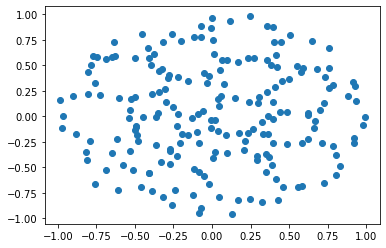

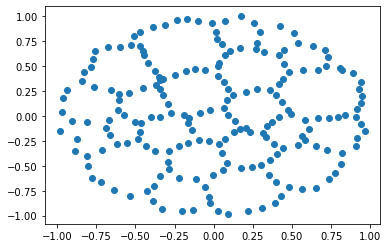

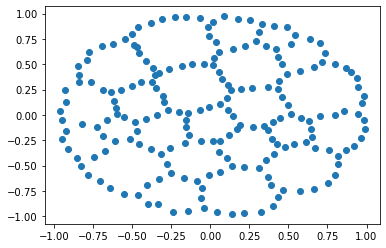

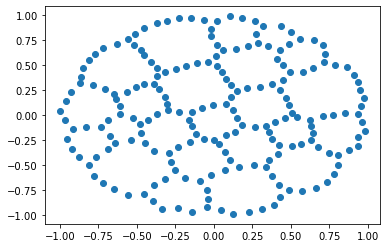

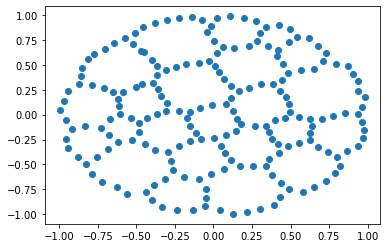

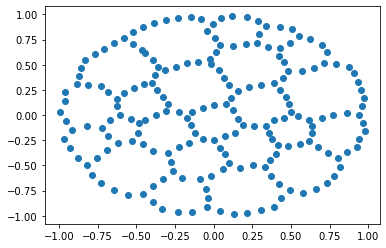

In [3]:
# Start with a square, the loss will round the corners
pts = (torch.rand((200, 2)) * 2 - 1).requires_grad_()
opt = torch.optim.SGD([pts], lr=1)
scheduler = LambdaLR(opt,[lambda epoch: 10./(10+epoch)])
for idx in range(600):
    opt.zero_grad()
    myloss(pts).backward()
    opt.step()
    scheduler.step()
    # Draw every 100 epochs
    if idx % 100 == 99:
        P = pts.detach().numpy()
        plt.scatter(P[:, 0], P[:, 1])
        plt.show()

## Hybrid Rips/alpha complex
Now instead of the Rips complex, let us use some hybrid construction using the persistence pairs of an α-complex filtration but replacing the filtration values with those of the Rips (this is not the same as what some call the weak α-complex, but yet another variant).

*Note that this relies on AlphaComplex indexing the vertices using the order of the input points, which with gudhi 3.3.0 works in all dimensions except 3.*

In [4]:
def myloss2(pts):
    alpha = gudhi.AlphaComplex(points=pts)
    st = alpha.create_simplex_tree()
    st.compute_persistence()
    p = st.persistence_pairs()
    # Keep only pairs that contribute to H1, i.e. (edge, triangle), and separate birth (p1b) and death (p1d)
    p1b = torch.tensor([i[0] for i in p if len(i[0]) == 2])
    p1d = torch.tensor([i[1] for i in p if len(i[0]) == 2])
    if len(p1b) == 0:
        # hack
        return torch.tensor(0., requires_grad=True)
    # Compute the distance between the extremities of the birth edge
    b = torch.norm(pts[p1b[:,1]] - pts[p1b[:,0]], dim=-1, keepdim=True)
    # For the death triangle, compute the maximum of the pairwise distances
    d_1 = torch.norm(pts[p1d[:,1]] - pts[p1d[:,0]], dim=-1, keepdim=True)
    d_2 = torch.norm(pts[p1d[:,1]] - pts[p1d[:,2]], dim=-1, keepdim=True)
    d_3 = torch.norm(pts[p1d[:,2]] - pts[p1d[:,0]], dim=-1, keepdim=True)
    d = torch.max(d_1, torch.max(d_2, d_3))
    # *Not* the same as the finite part of st.persistence_intervals_in_dimension(1)
    diag1 = torch.cat((b,d), 1)
    # Total persistence is a special case of Wasserstein distance
    perstot1 = wasserstein_distance(diag1, [], order=1, enable_autodiff=True)
    # Stay within the unit disk
    disk = (pts ** 2).sum(-1) - 1
    disk = torch.max(disk, torch.zeros_like(disk)).sum()
    return -perstot1 + 1 * disk

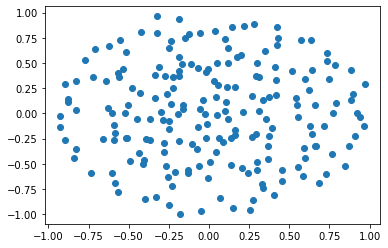

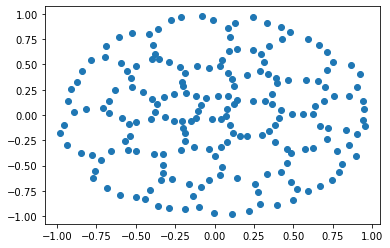

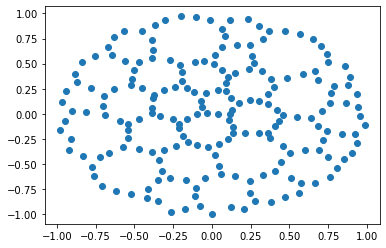

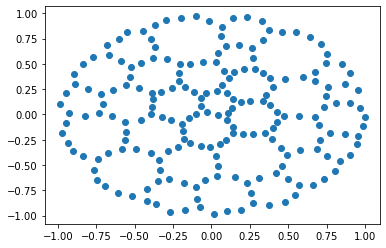

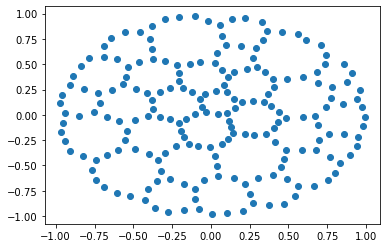

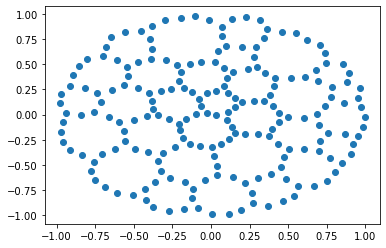

In [5]:
# Start with a square, the loss will round the corners
pts = (torch.rand((200, 2)) * 2 - 1).requires_grad_()
opt = torch.optim.SGD([pts], lr=1)
scheduler = LambdaLR(opt,[lambda epoch: 10./(10+epoch)])
for idx in range(600):
    opt.zero_grad()
    myloss2(pts).backward()
    opt.step()
    scheduler.step()
    if idx % 100 == 99:
        P = pts.detach().numpy()
        plt.scatter(P[:, 0], P[:, 1])
        plt.show()

## Weak α-complex.

*Note that this relies on AlphaComplex indexing the vertices using the order of the input points, which with gudhi 3.3.0 works in all dimensions except 3.*

In [6]:
def myloss3(pts):
    alpha = gudhi.AlphaComplex(points=pts)
    # Build the Delaunay triangulation
    st = alpha.create_simplex_tree(default_filtration_value=True)
    X = pts.detach().numpy()
    for s in st.get_skeleton(1):
        if len(s[0]) == 1:
            # vertex
            st.assign_filtration(s[0], 0)
        else:
            # edge length
            st.assign_filtration(s[0], ((X[s[0][1]] - X[s[0][0]]) ** 2).sum())
    # For triangles, use the max of the edges
    st.make_filtration_non_decreasing()
    st.compute_persistence()
    p = st.persistence_pairs()
    # Keep only pairs that contribute to H1, i.e. (edge, triangle), and separate birth (p1b) and death (p1d)
    p1b = torch.tensor([i[0] for i in p if len(i[0]) == 2])
    p1d = torch.tensor([i[1] for i in p if len(i[0]) == 2])
    if len(p1b) == 0:
        return torch.tensor(0., requires_grad=True)
    # Compute the distance between the extremities of the birth edge
    b = torch.norm(pts[p1b[:,1]] - pts[p1b[:,0]], dim=-1, keepdim=True)
    # For the death triangle, compute the maximum of the pairwise distances
    d_1 = torch.norm(pts[p1d[:,1]] - pts[p1d[:,0]], dim=-1, keepdim=True)
    d_2 = torch.norm(pts[p1d[:,1]] - pts[p1d[:,2]], dim=-1, keepdim=True)
    d_3 = torch.norm(pts[p1d[:,2]] - pts[p1d[:,0]], dim=-1, keepdim=True)
    d = torch.max(d_1, torch.max(d_2, d_3))
    # Same as the finite part of st.persistence_intervals_in_dimension(1), but differentiable
    diag1 = torch.cat((b,d), 1)
    # Total persistence is a special case of Wasserstein distance
    perstot1 = wasserstein_distance(diag1, [], order=1, enable_autodiff=True)
    # Stay within the unit disk
    disk = (pts ** 2).sum(-1) - 1
    disk = torch.max(disk, torch.zeros_like(disk)).sum()
    return -perstot1 + 1 * disk

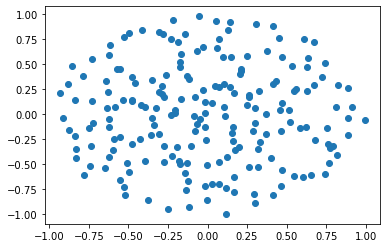

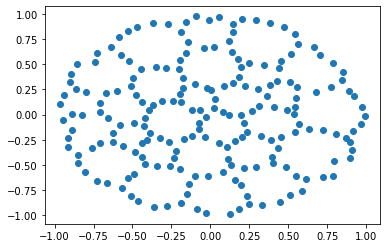

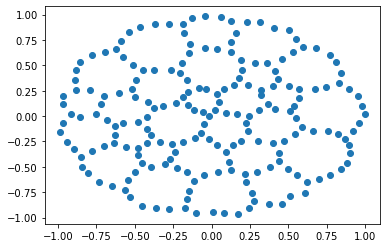

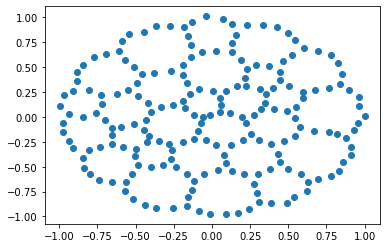

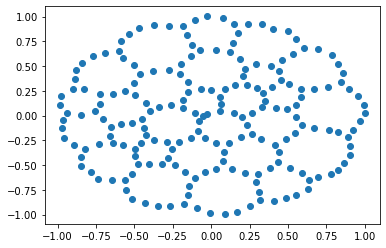

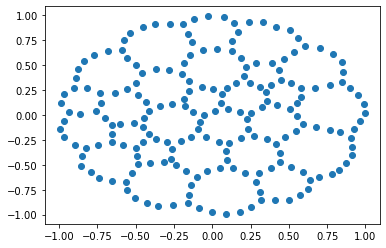

In [7]:
# Start with a square, the loss will round the corners
pts = (torch.rand((200, 2)) * 2 - 1).requires_grad_()
opt = torch.optim.SGD([pts], lr=1)
scheduler = LambdaLR(opt,[lambda epoch: 10./(10+epoch)])
for idx in range(600):
    opt.zero_grad()
    myloss3(pts).backward()
    opt.step()
    scheduler.step()
    if idx % 100 == 99:
        P = pts.detach().numpy()
        plt.scatter(P[:, 0], P[:, 1])
        plt.show()